Author: Shan Qu, Delft University of Technology

First created: 4 April 2021; latest modifed: 7 April 2021

Product: credit modeling --- training the model using Logistic regression


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

%run helpers.ipynb


pd.set_option('display.max_columns', 20)
seed = 143

import warnings
warnings.filterwarnings("ignore")

model = LogisticRegression()

In [2]:
df_X_train = pd.read_csv('Data/df_X_train.csv')
df_X_val = pd.read_csv('Data/df_X_val.csv')
df_y_train = pd.read_csv('Data/df_y_train.csv')
df_y_val = pd.read_csv('Data/df_y_val.csv')
print(df_X_train.info())
print(df_y_train.info())

# drop the unnamed ID column
df_X_train.drop('Unnamed: 0', axis=1, inplace=True)
df_X_val.drop('Unnamed: 0', axis=1, inplace=True)
df_y_train.drop('Unnamed: 0', axis=1, inplace=True)
df_y_val.drop('Unnamed: 0', axis=1, inplace=True)

df_X_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         506 non-null    int64  
 1   duration           506 non-null    float64
 2   credit_amount      506 non-null    float64
 3   installment_rate   506 non-null    float64
 4   residence_length   506 non-null    float64
 5   age                506 non-null    float64
 6   existing_credits   506 non-null    float64
 7   liable_people      506 non-null    float64
 8   checking_account   506 non-null    float64
 9   credit_history     506 non-null    float64
 10  purpose            506 non-null    float64
 11  savings_account    506 non-null    float64
 12  employment_length  506 non-null    float64
 13  status_sex         506 non-null    float64
 14  other_debtors      506 non-null    float64
 15  property           506 non-null    float64
 16  installment_plan   506 non

,duration,credit_amount,installment_rate,residence_length,age,existing_credits,liable_people,checking_account,credit_history,purpose,savings_account,employment_length,status_sex,other_debtors,property,installment_plan,housing,job,telephone,foreign_worker
0,0.294118,0.269616,1.0,1.000000,0.250000,0.000000,0.0,0.0,0.000000,0.636409,1.000000,0.157661,0.000000,0.436055,0.424937,0.0,0.0,0.235904,0.0,1.0
1,0.647059,0.687741,1.0,0.000000,0.321429,0.000000,0.0,0.0,0.324712,0.335297,0.211197,0.000000,0.000000,0.436055,0.424937,0.0,0.0,1.000000,0.0,1.0
2,0.470588,0.155662,1.0,1.000000,0.303571,0.000000,0.0,0.0,0.326222,0.818572,0.212304,0.452020,0.000000,0.436055,0.000000,0.0,0.0,0.235904,1.0,1.0
3,0.073529,0.048861,1.0,1.000000,0.107143,0.333333,0.0,1.0,0.000000,0.335297,1.000000,0.452020,0.000000,0.436055,0.000000,0.0,0.0,0.000000,1.0,1.0
4,0.088235,0.035435,1.0,0.666667,0.375000,0.000000,0.0,0.0,0.326222,0.000000,0.212304,0.000000,0.637758,0.436055,0.419563,0.0,0.0,0.235904,0.0,1.0


## 3. Credit modeling

#### 3.1 Tune hyperparameters via GridSearchCV

Logistic regression

solver: ['newton-cg', 'lbfgs', 'liblinear']

penalty: ['none', 'l1', 'l2', 'elasticnet']

C (controls the penality strength): [100, 10, 1.0, 0.1, 0.01]

In [3]:
hyperparam_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none', 'l1', 'l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=seed)
grid_search = GridSearchCV(model, param_grid=hyperparam_grid, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

model_bestparam = grid_search.best_estimator_
print(model_bestparam)

Fitting 15 folds for each of 45 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8024903242342689
{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:    5.2s finished


### 3.2 Fit the model using the selected hyperparameters and predict PD using the validation data

[[98 55]
 [ 6 41]]
              precision    recall  f1-score   support

        good       0.94      0.64      0.76       153
         bad       0.43      0.87      0.57        47

    accuracy                           0.69       200
   macro avg       0.68      0.76      0.67       200
weighted avg       0.82      0.69      0.72       200

0.7564316506744542


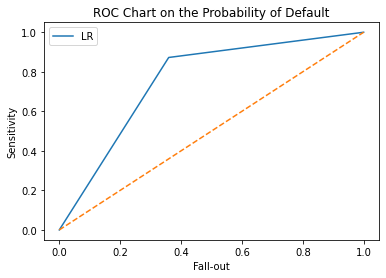

In [4]:
preds = model_bestparam.predict_proba(df_X_val)
df_preds = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.4
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds['Risk_pred']))
print(classification_report(df_y_val, df_preds['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds['Risk_pred']))


plot_roc_PD(df_preds, df_y_val, 'LR')

### 3.3 Select proper threshold
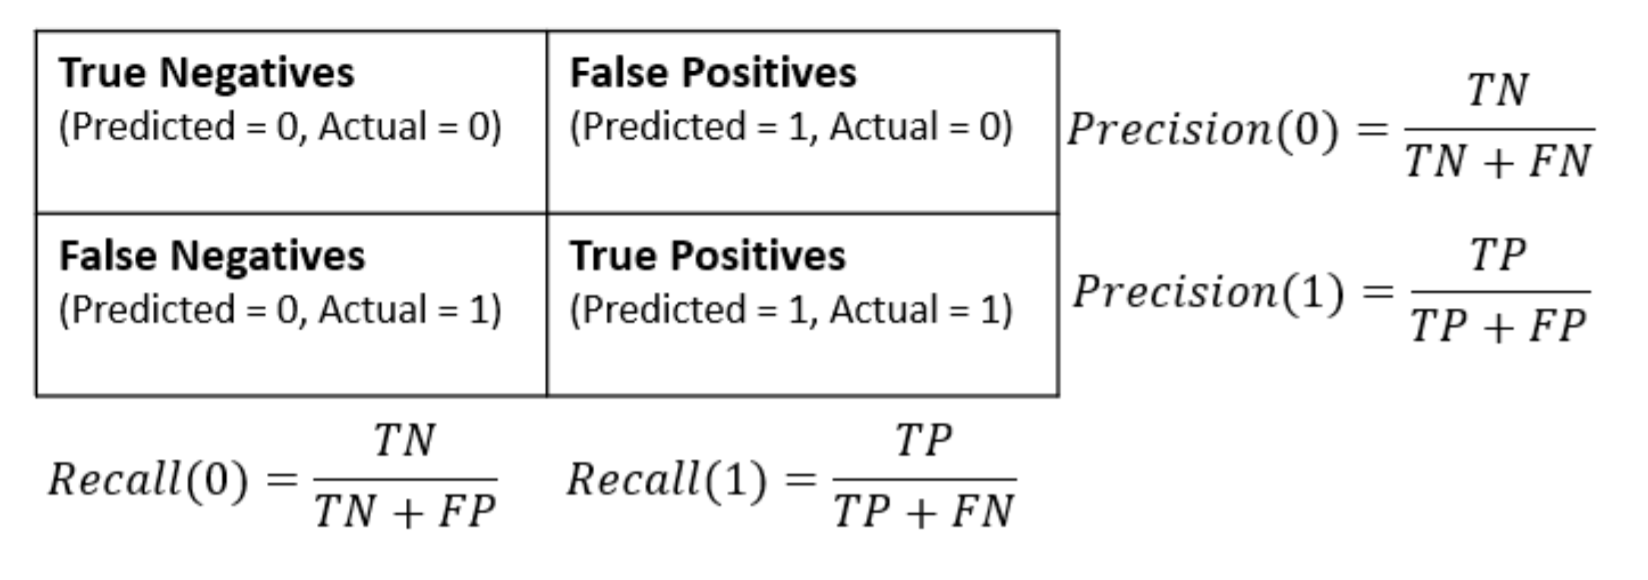

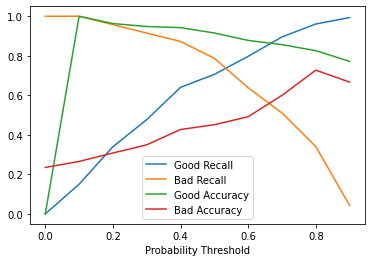

threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management


In [5]:
plot_prob_thresh(df_preds, df_y_val)
plt.show()

print("threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management")

Average precision-recall score: 0.60


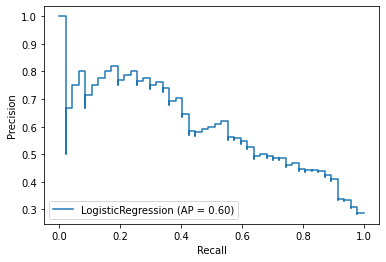

In [6]:
y_score = model_bestparam.decision_function(df_X_val)

average_precision = average_precision_score(df_y_val, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

plot_precision_recall_curve(model_bestparam, df_X_val, df_y_val)
plt.show()

### 3.4 Feature selection using coefficents of Logistic regression

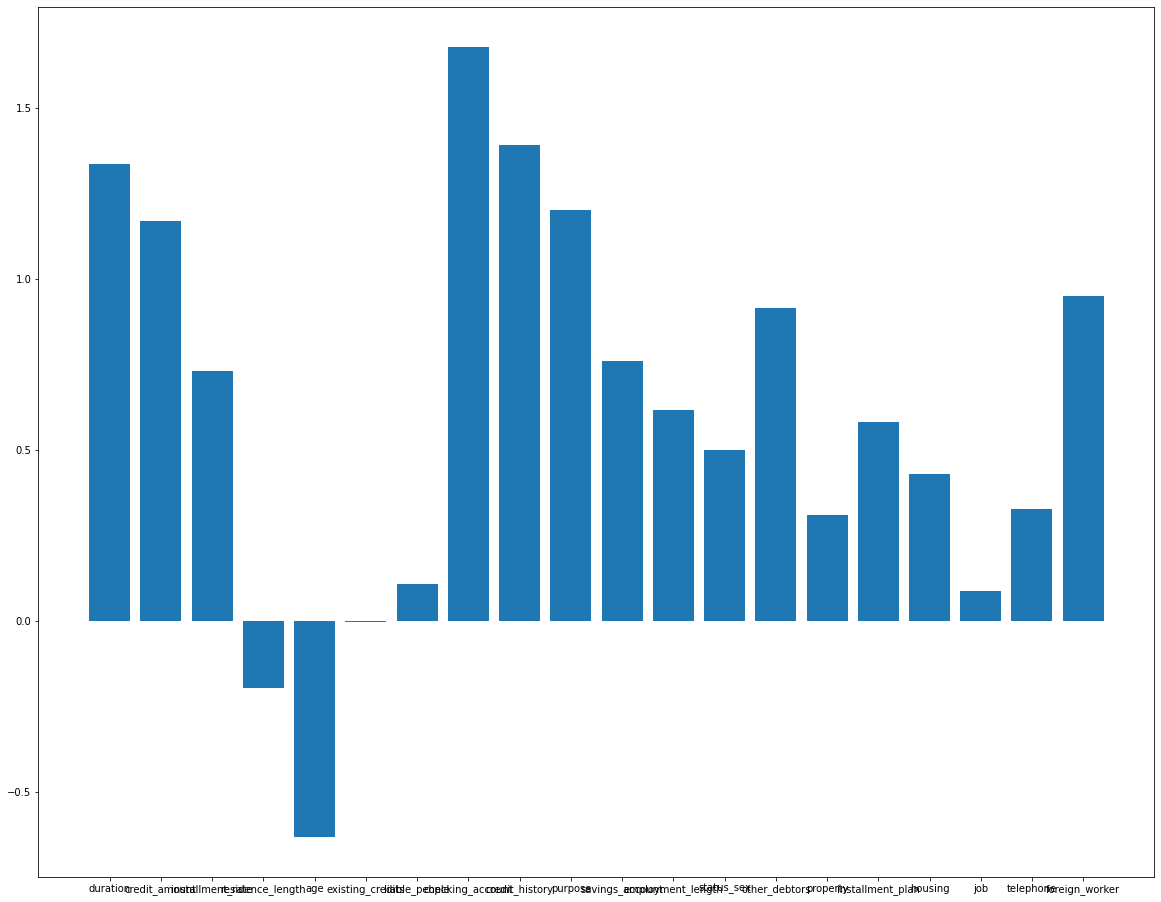

[ True  True False False False False False  True  True  True  True False
 False  True False False False False False  True]
8
Index(['duration', 'credit_amount', 'checking_account', 'credit_history',
       'purpose', 'savings_account', 'other_debtors', 'foreign_worker'],
      dtype='object')


In [7]:
model.fit(df_X_train, np.ravel(df_y_train))
importance = model.coef_[0]
plt.figure(figsize=(20,16))
plt.bar([df_X_train.columns[x] for x in range(len(importance))], importance)
plt.show()

bool_selection = np.abs(importance) >= 1.2*np.median(abs(importance))
print(bool_selection)
print(np.sum(bool_selection))

#selector = SelectFromModel(LogisticRegression(solver='liblinear', penalty="l1"), threshold = '1.25*median')
#selector.fit(df_X_train, df_y_train)
#print(selector.get_support())
print(df_X_train.loc[:, bool_selection].columns)
df_X_train_selected = df_X_train.loc[:, bool_selection]
df_X_val_selected = df_X_val.loc[:, bool_selection]

### 3.5 Re-tune the hyperparameters using selected features

In [8]:
grid_search = GridSearchCV(model, param_grid=hyperparam_grid, cv=cv, scoring='roc_auc', verbose=1)
grid_search.fit(df_X_train_selected, np.ravel(df_y_train))

print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

model_bestparam_selected = grid_search.best_estimator_
print(model_bestparam_selected)


Fitting 15 folds for each of 45 candidates, totalling 675 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7948829937203641
{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)


[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed:    4.2s finished


[[93 60]
 [ 9 38]]
              precision    recall  f1-score   support

        good       0.91      0.61      0.73       153
         bad       0.39      0.81      0.52        47

    accuracy                           0.66       200
   macro avg       0.65      0.71      0.63       200
weighted avg       0.79      0.66      0.68       200

0.7081768877763872


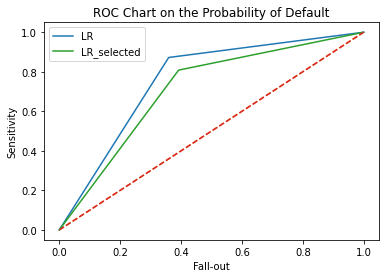

In [9]:
preds = model_bestparam_selected.predict_proba(df_X_val_selected)
df_preds_selected  = pd.DataFrame(preds[:,1], columns = ['prob_default'])

threshold = 0.4
df_preds_selected['Risk_pred'] = df_preds_selected['prob_default'].apply(lambda x: 1 if x > threshold else 0)
df_preds['Risk_pred'] = df_preds['prob_default'].apply(lambda x: 1 if x > threshold else 0)

print(confusion_matrix(df_y_val, df_preds_selected['Risk_pred']))
print(classification_report(df_y_val, df_preds_selected['Risk_pred'], target_names= ['good', 'bad']))
print(roc_auc_score(df_y_val, df_preds_selected['Risk_pred']))

plot_roc_PD(df_preds, df_y_val, 'LR')
plot_roc_PD(df_preds_selected, df_y_val, 'LR_selected')
plt.show()

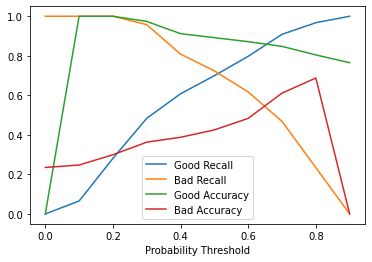

threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management


In [10]:
plot_prob_thresh(df_preds_selected, df_y_val)
plt.show()

print("threshold can be choosen as 0.35-0.4, so that the Bad Recall can be higher, since we do not like false negative in credit management")

### 3.6 Save the predicted validation data for comparision

In [11]:
df_preds.to_csv('df_preds_LR.csv')